In [1]:
import copy
import cv2
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import time
import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms as TF
from torchvision.transforms import functional as F

In [4]:
dataset_dir = './embedding_data/vidit'
out_dir = './embedding_data/vidit_out'

train_file = './embedding_data/vidit_train.txt'
test_file = './embedding_data/vidit_test.txt'

In [5]:
img_path = os.path.join(dataset_dir, os.listdir(dataset_dir)[0])
images = [os.path.join(dataset_dir, image_name) for image_name in os.listdir(dataset_dir)]
print(img_path)
print(len(images))

./indoor_hdr/9C4A6257-3cc71c714b.exr
1681


In [6]:
def gamma_correction(img, gamma=5):
    return np.clip(np.power(img, 1.0 / gamma), 0.0, 1.0).astype(np.float32)


def to_ldr(img_hdr, gamma=2.2):
    tonemap = cv2.createTonemapReinhard(gamma, 0, 0, 0)
    return (tonemap.process(img_hdr) * 255).astype(np.uint8)


def read_hdr(path):
    hdr_img = cv2.imread(path, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR)
    return cv2.cvtColor(hdr_img, cv2.COLOR_BGR2RGB).astype('float32')


def write_hdr(path, hdr_img):
    hdr_bgr = cv2.cvtColor(hdr_img, cv2.COLOR_RGB2BGR).astype('float32')
    cv2.imwrite(path, hdr_bgr, [cv2.IMWRITE_EXR_TYPE_FLOAT])


def write_ldr(path, ldr_img):
    ldr_img1 = cv2.cvtColor(ldr_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, ldr_img1)

In [7]:
def light_sources_mask(hdr_image):
    treshold = np.percentile(hdr_image, 99)
    mask_rgb = (hdr_image > treshold).astype(np.uint8)
    mask = np.max(mask_rgb, axis=2)
    return mask

In [8]:
def show_light(hdr_img):
    img = to_ldr(hdr_img.copy())

    mask = light_sources_mask(hdr_img)
    mask_rgb = np.stack([mask for _ in range(3)], axis=2)
    img1 = img * (1 - mask_rgb) + mask_rgb * np.array([0, 255, 255])

    fig = plt.figure(figsize=(15, 8))
    plt.imshow(img1)
    plt.show()

In [9]:
def to_pil(cv2_img):
    cv2_img1 = cv2.cvtColor(cv2_img.copy(), cv2.COLOR_BGR2RGB)
    return Image.fromarray(cv2_img1)

def from_pil(pil_img):
    img = np.array(pil_img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img


def adjust_image_param(img, func, lower_value, higher_value):
    original_image = to_pil(img)

    lower_param_image = func(original_contrast.copy(), lower_value)
    higher_param_image = func(original_contrast.copy(), higher_value)

    composed_contrast_adjusted = np.concatenate(
        list(map(from_pil, [lower_param_image, original_image, higher_param_image])),
        axis=1)
    show_ldr(composed_contrast_adjusted)

In [10]:
nfov = NFOV(height=512, width=384, FOV=[0.30, 0.90])

nfov_h = NFOV(height=512, width=384, FOV=[0.20, 0.60])
nfov_w = NFOV(height=1024, width=1024, FOV=[0.75, 0.75])

def crop(img, point, dt='uint8'):
    cropped = nfov.toNFOV(img, point, dt)
    return cv2.resize(cropped, (nfov.width, nfov.height)).astype(dt)


def crop1(nfover, img, point, dt='uint8'):
    cropped = nfover.toNFOV(img, point, dt)
    return cv2.resize(cropped, (nfover.width, nfover.height)).astype(dt)


def crop_pair(img, point, dt='uint8'):
    cropped_w = crop1(nfov_w, img, point, dt)
    cropped_h = crop1(nfov_h, img, point, dt)
    return (cropped_w, cropped_h)


n_crops = 5


def crop_points():
    w = np.random.random(size=(n_crops, 1))
    h = np.random.random(size=(n_crops, 1)) * 0.35 + 0.2
    return np.concatenate((w, h), axis=1)


def crop_point1():
    w = np.random.random()
    h = np.random.random() * 0.35 + 0.2
    return np.array([w, h])

def random_fov_crop(img):
    return crop1(nfov_w, img, crop_point1())

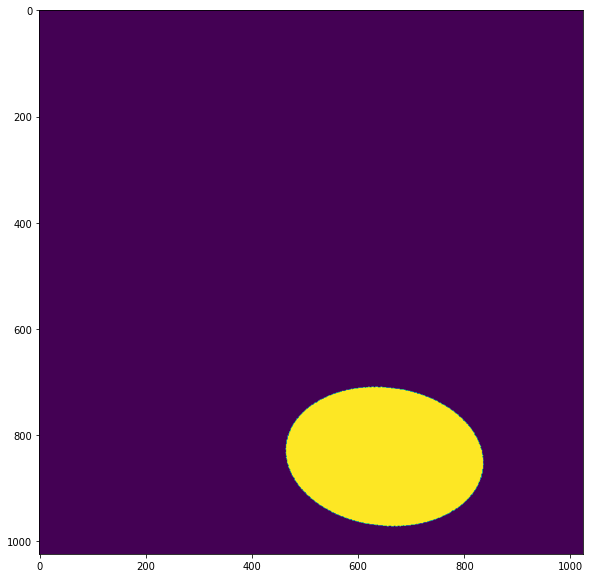

In [155]:
# # np.random.seed(1338)

# a = np.random.randint(256, 512)
# b = np.random.randint(256, 512)

# img12 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (a, b))
# fig = plt.figure(figsize=(10, 10))
# # plt.imshow(img12)
# # plt.show()

# tf = TF.Compose([
#     TF.RandomRotation(90, expand=True)
# ])

# pil_img12 = Image.fromarray(img12)
# img13 = np.array(tf(pil_img12))
# th, tw = img13.shape

# BIG_SZ = (1024, 1024)
# ph = np.random.randint(1024 - th)
# pw = np.random.randint(1024 - tw)
# mask = np.zeros((1024, 1024))
# mask[ph:ph+th, pw:pw+tw] = img13

# plt.imshow(mask)
# plt.show()

In [ ]:
# def get_random_mask():
#     a = np.random.randint(256, 512)
#     b = np.random.randint(256, 512)

#     ellipsis = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (a, b))
#     tf = TF.RandomRotation(90, expand=True)
#     small_mask = np.array(tf(Image.fromarray(ellipsis)))
#     th, tw = small_mask.shape
    
#     ph = np.random.randint(1024 - th)
#     pw = np.random.randint(1024 - tw)
#     mask = np.zeros((1024, 1024))
#     mask[ph:ph+th, pw:pw+tw] = small_mask
#     return mask

In [ ]:
np.random.seed(1337)

subdir_name = datetime.now().strftime("%d_%b_%H_%M_%S")
subdir = os.path.join(base_dir, subdir_name)

if not os.path.exists(subdir):
    os.mkdir(subdir)

hdr_crops_dir = os.path.join(subdir, 'crops_hdr')
if not os.path.exists(hdr_crops_dir):
    os.mkdir(hdr_crops_dir)

ldr_crops_dir = os.path.join(subdir, 'crops_ldr')
if not os.path.exists(ldr_crops_dir):
    os.mkdir(ldr_crops_dir)

WIMG_SIZE = (1024, 1024)

PROD = True


all_images = hdr_images if PROD else hdr_images[:3]
for image_path in all_images:
    name, _ = os.path.basename(image_path).split('.')
    h, w = WIMG_SIZE

    try:
        hdr_img = read_hdr(image_path)
        hdr_img = cv2.resize(hdr_img, WIMG_SIZE, interpolation = cv2.INTER_CUBIC)
        
        points = crop_points()
        cropped_hdrs = [crop1(nfov_w, hdr_img.copy(), point, dt='float32') for point in points]

        for i, cropped_hdr in enumerate(cropped_hdrs):
            new_name = f'{name}_{i}'
            cropped_hdr_path = os.path.join(hdr_crops_dir, f'{new_name}.exr')
            cropped_ldr_path = os.path.join(ldr_crops_dir, f'{new_name}.png')
            cropped_ldr = to_ldr(cropped_hdr)
            
            if not PROD and i == 0:
                print(cropped_ldr_path)
                fig = plt.figure(figsize=(10, 10))
                plt.imshow(cropped_ldr)
                plt.show()
                

            write_hdr(cropped_hdr_path, cropped_hdr)
            write_ldr(cropped_ldr_path, cropped_ldr)
    except Exception as e:
        print(e)
        if not PROD:
            raise e
